In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Load data into pandas
DATASET_LOC = "/content/drive/MyDrive/Trajectories/datasets/manual_trajectories"
expert = pd.read_csv(os.path.join(DATASET_LOC,"expert.csv"))
pgy4 = pd.read_csv(os.path.join(DATASET_LOC,"pgy4.csv"))
pgy2 = pd.read_csv(os.path.join(DATASET_LOC,"pgy2.csv"))
trajectories = [expert, pgy4, pgy2]

In [19]:
print(trajectories)

[     Unnamed: 0       x       y  frame  pull
0             0  594.50 -478.00    100     0
1             1  595.63 -478.87    101     0
2             2  596.77 -479.73    102     0
3             3  597.90 -480.60    103     0
4             4  598.92 -480.78    104     0
..          ...     ...     ...    ...   ...
433         433  817.60 -255.70     60     3
434         434  814.20 -260.53     61     3
435         435  810.80 -265.37     62     3
436         436  807.40 -270.20     63     3
437         437  807.40 -270.20     64     3

[438 rows x 5 columns],       Unnamed: 0       x       y  frame  pull
0              0  295.00 -283.33    357     0
1              1  294.88 -282.01    358     0
2              2  294.76 -280.68    359     0
3              3  294.64 -279.35    360     0
4              4  294.52 -278.03    361     0
...          ...     ...     ...    ...   ...
1810        1810  428.10 -442.30   2556     5
1811        1811  428.10 -442.30   2557     5
1812        1812  42

# Exploratory Visualization

## Full Trajectories

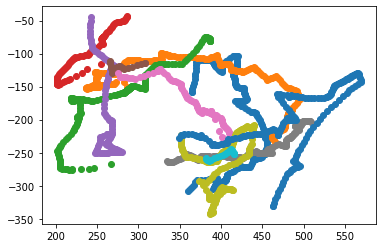

In [5]:
# Plot PGY2 trajectory
for i in range(max(pgy2['pull']) + 1):
  plt.scatter(pgy2[pgy2['pull'] == i]['x'], pgy2[pgy2['pull'] == i]['y'])

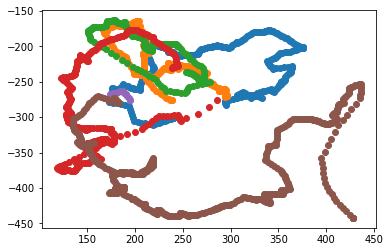

In [6]:
# Plot PGY4 trajectory
for i in range(max(pgy4['pull']) + 1):
  plt.scatter(pgy4[pgy4['pull'] == i]['x'], pgy4[pgy4['pull'] == i]['y'])

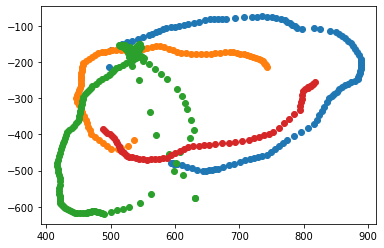

In [7]:
# Plot expert trajectory
for i in range(max(expert['pull']) + 1):
  plt.scatter(expert[expert['pull'] == i]['x'], expert[expert['pull'] == i]['y'])

## Individual Pulls

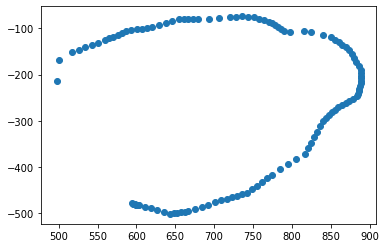

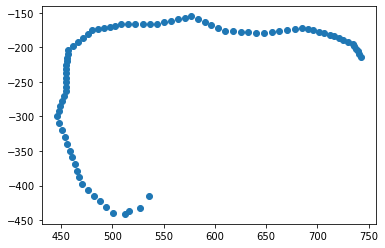

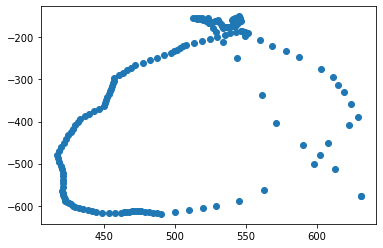

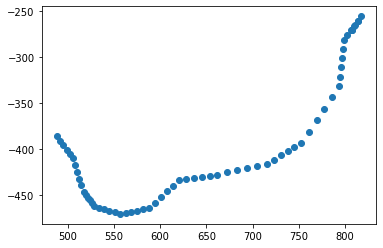

In [8]:
# Plot all 4 pulls in expert trajectory
for i in range(max(expert['pull']) + 1):
  plt.figure()
  plt.scatter(expert[expert['pull'] == i]['x'], expert[expert['pull'] == i]['y'])
plt.show()

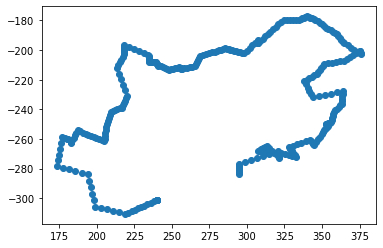

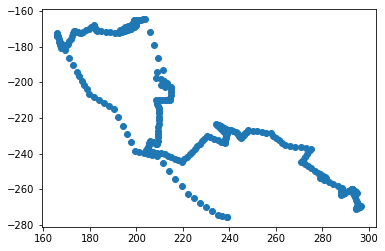

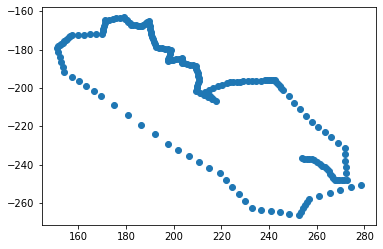

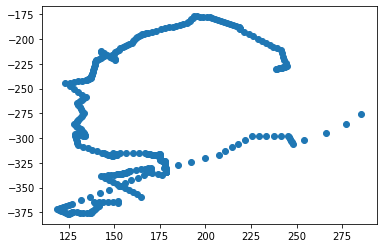

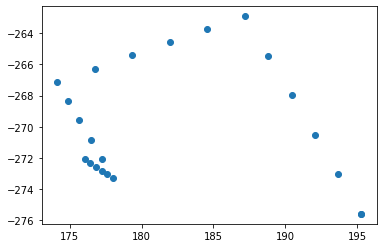

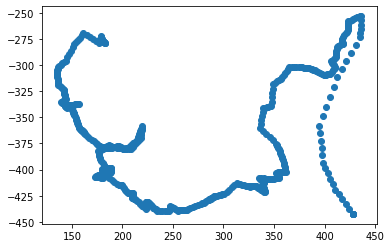

In [9]:
# Plot all PGY4 trajectories
for i in range(max(pgy4['pull']) + 1):
  plt.figure()
  plt.scatter(pgy4[pgy4['pull'] == i]['x'], pgy4[pgy4['pull'] == i]['y'])
plt.show()

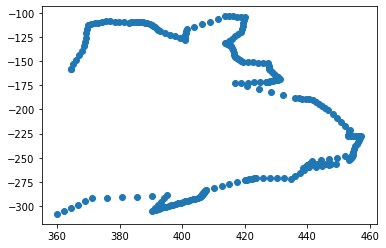

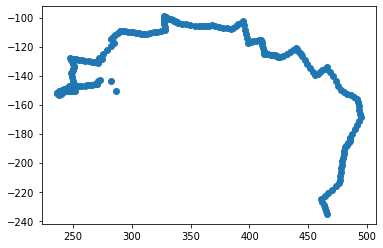

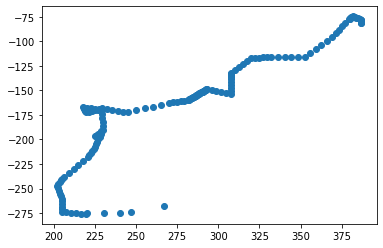

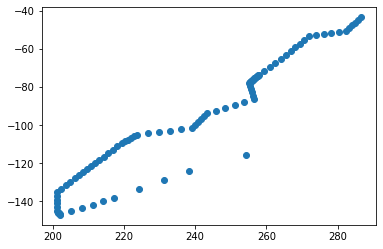

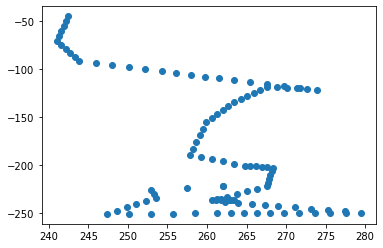

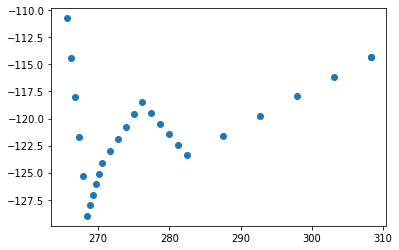

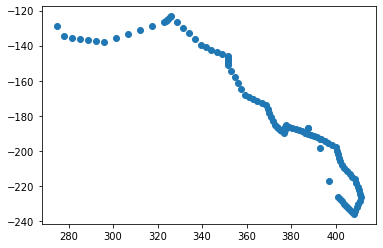

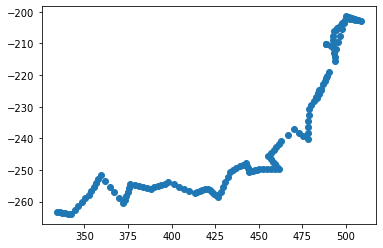

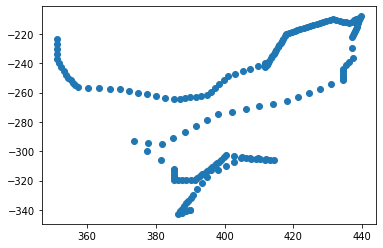

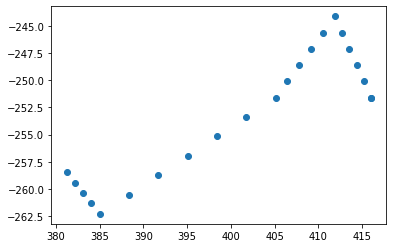

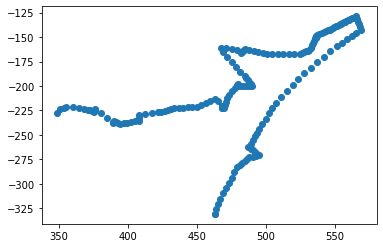

In [10]:
# Plot all PGY2 trajectories
for i in range(max(pgy2['pull']) + 1):
  plt.figure()
  plt.scatter(pgy2[pgy2['pull'] == i]['x'], pgy2[pgy2['pull'] == i]['y'])
plt.show()

# Feature Extraction Functions

In [11]:
def pull_to_length(pull):
    """
    Args:
      pull: The dataframe for the pull to conver to velocities
  
    Return:
      velocities: velocities calculated as distance traveled per frame
    """
    return len(pull.x)

In [12]:
def pull_to_velocities_and_accelerations(pull):
  """
  Args:
    pull: The dataframe for the pull to conver to velocities
  
  Return:
    mean velocity: velocity calculated as distance traveled per frame
    mean acceleration: acceleration calculated as change in velocity between frames
  """
  x, y = pull.x, pull.y
  velocities = []
  accelerations = []

  for i in range(len(x)-1):
    x1, x2 = x[i:i+2]
    y1, y2 = y[i:i+2]
    velocities.append(np.sqrt(np.square(x2 - x1) + np.square(y2 - y1)))

  for i in range(len(velocities) - 1):
    accelerations.append(np.abs(velocities[i+1] - velocities[i]))

  return (np.mean(velocities), np.mean(accelerations))

In [13]:
def pull_to_angles(pull):
  """
  Args:
    pull: The dataframe for the pull to convert to angles

  Return:
    angles: The angles for each triple of datapoints
  """
  x, y = pull.x, pull.y
  angles = []
  for i in range(len(x)-2):
    x1, x2, x3 = x[i:i+3]
    y1, y2, y3 = y[i:i+3]
    v1 = np.array([x1-x2, y1-y2])
    v2 = np.array([x3-x2, y3-y2])
    angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))
    angle_floor = np.where(angle_nocos < -1, -1.0, angle_nocos)
    angle_ceil = np.where(angle_floor > 1, 1.0, angle_floor) 
    angle = np.arccos(angle_ceil) * 180 / np.pi
    angles.append(angle)
  return angles

In [14]:
def angles_to_bins(angles):
  """
  Args:
    angles: the list of angles to bin

  Returns:
    histogram: histogram values
    bins: histogram bins
  """
  bins = [i for i in range(0, 181, 180//num_bins)] 
  return np.histogram(angles, bins)


In [15]:
def featurize_pull(pull):
  """
  Performs all featurizations for an individual pull

  Args:
    pull: The pull dataframe to convert to a feature row

  Returns:
    row: A feature row for the pull
  """
  angles = pull_to_angles(pull)
  hist, bins = angles_to_bins(angles)

  length = pull_to_length(pull)
  mean_velocity, mean_accel = pull_to_velocities_and_accelerations(pull)

  features = np.append(hist, np.array([length, mean_velocity, mean_accel]))

  return features

In [16]:
def featurize_trajectory(trajectory, label):
  """
  Splits a trajectory by pulls and featurizes each pull. Each pull is assigned
  the input label.

  Args:
    trajectory: The trajectory dataframe to split into featurized pulls
    label: The label to assign each pull for the trajectory
  
  Return:
    X: The feature rows
    y: The labels for each row
  """
  X = [featurize_pull(df) for val, df in trajectory.groupby('pull')]
  y = np.repeat(label, len(X))
  return np.array(X), y

In [17]:
def featurize_trajectories(trajectories):
  """
  Converts a list of trajectories into a feature matrix and label vector

  Args:
    trajectory: The trajctory dataframe to split into featurized pulls
    label: The label to assign each pull for the trajectory
  
  Return:
    X: The feature matrix
    y: The label vector
  """
  featurized_trajectory_list = [featurize_trajectory(t, i) for i, t in enumerate(trajectories)]
  X = np.row_stack([x for x, y in featurized_trajectory_list])
  y = np.concatenate([y for x, y in featurized_trajectory_list])
  return X, y

# Model Fitting/Prediction

In [18]:
X, y = featurize_trajectories(trajectories)
y

NameError: ignored

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Keep deterministic
np.random.seed(42)
sss = StratifiedShuffleSplit(1, test_size=.2)
train_ind, test_ind =  next(sss.split(X, y))
X_train, X_test = X[train_ind], X[test_ind]
y_train, y_test = y[train_ind], y[test_ind]
# Print to check class balance
y_train, y_test

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, multi_class="multinomial", max_iter=1000).fit(X_train, y_train)
clf.score(X_test, y_test)